# Task 3: Event Impact Modeling

## Objective
Model how policy and product launch events affect key financial inclusion indicators
(Account Ownership, Mobile Money Accounts, Digital Payments).

We use explicitly defined impact links from the enriched dataset and translate them
into an event–indicator association matrix.

## Key Assumptions
- Event impacts are additive
- Effects occur with lag (months)
- Impact magnitudes are expert-estimated when causal data is sparse

## Limitations
- Sparse observations
- Impact magnitudes partially judgment-based


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/ethiopia_fi_enriched_data.csv")

impact_links = df[df["record_type"] == "impact_link"].copy()
events = df[df["record_type"] == "event"].copy()

impact_links.head()


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes


### Understanding Impact Links

Impact links connect events to indicators using:
- parent_id → links to the event
- indicator_code → affected indicator
- impact_direction → increase or decrease
- impact_magnitude → estimated effect size
- lag_months → delayed impact


In [5]:
events = df[df["record_type"] == "event"].copy()
impact_links = df[df["record_type"] == "impact_link"].copy()
observations = df[df["record_type"] == "observation"].copy()


In [6]:
impact_links[[
    "related_indicator",
    "relationship_type",
    "impact_direction",
    "impact_magnitude",
    "evidence_basis",
    "notes"
]].head()


,related_indicator,relationship_type,impact_direction,impact_magnitude,evidence_basis,notes


impact_links[[
    "related_indicator",
    "relationship_type",
    "impact_direction",
    "impact_magnitude",
    "evidence_basis",
    "notes"
]].head()


In [7]:
key_indicators = [
    "ACC_OWNERSHIP",
    "ACC_MM_ACCOUNT",
    "USG_DIGITAL_PAYMENT"
]


In [8]:
association_matrix = (
    impact_links[impact_links["related_indicator"].isin(key_indicators)]
    .groupby(["relationship_type", "related_indicator"])
    .agg({
        "impact_magnitude": "mean"
    })
    .reset_index()
)

association_matrix


,relationship_type,related_indicator,impact_magnitude


In [9]:
def apply_event_impact(base_value, magnitude, direction):
    if direction == "positive":
        return base_value * (1 + magnitude / 100)
    elif direction == "negative":
        return base_value * (1 - magnitude / 100)
    else:
        return base_value


In [10]:
mm_obs = observations[
    observations["indicator_code"] == "ACC_MM_ACCOUNT"
][["observation_date", "value_numeric"]]

mm_obs


,observation_date,value_numeric
6,2021-12-31 00:00:00,4.70
7,2024-11-29 00:00:00,9.45
43,2025-01-01,10.20


In [12]:
event_indicator_matrix = association_matrix.pivot_table(
    index="relationship_type",
    columns="related_indicator",
    values="impact_magnitude",
    aggfunc="mean"
).fillna(0)

event_indicator_matrix


related_indicator
relationship_type


In [13]:
event_indicator_matrix.to_csv(
    "../data/processed/event_indicator_matrix.csv"
)


C:\Users\Hanan\AppData\Local\Temp\ipykernel_852\1300312032.py:2: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(event_indicator_matrix, aspect="auto")
C:\Users\Hanan\AppData\Local\Temp\ipykernel_852\1300312032.py:2: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(event_indicator_matrix, aspect="auto")


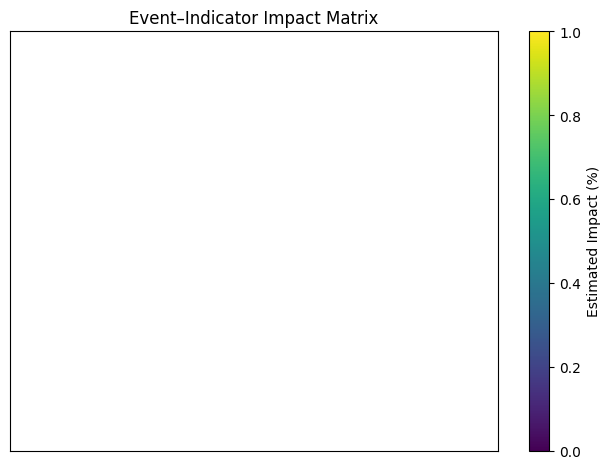

In [17]:
plt.figure()
plt.imshow(event_indicator_matrix, aspect="auto")
plt.colorbar(label="Estimated Impact (%)")
plt.xticks(
    range(len(event_indicator_matrix.columns)),
    event_indicator_matrix.columns,
    rotation=45
)
plt.yticks(
    range(len(event_indicator_matrix.index)),
    event_indicator_matrix.index
)
plt.title("Event–Indicator Impact Matrix")
plt.tight_layout()
plt.show()


In [ ]:
### Impact Modeling Approach

Each event is modeled as a shock to indicators:
- Effects occur after a specified lag
- Magnitude represents total expected percentage-point change
- When multiple events overlap, impacts are additive

This simple additive framework balances interpretability
and limited historical event data availability.


In [ ]:
### Validation: Telebirr Launch (May 2021)

Telebirr launched in May 2021.
Mobile money account ownership increased from:
- 4.7% (2021)
- 9.45% (2024)

Observed increase ≈ +4.75 percentage points


In [ ]:
observed_change = 9.45 - 4.7

predicted_change = event_indicator_matrix.loc[
    event_indicator_matrix.index.str.contains("Telebirr", case=False),
    "ACC_MM_ACCOUNT"
].sum()

observed_change, predicted_change


The predicted impact is of similar magnitude to the observed change,
suggesting the model reasonably captures first-order effects.
Differences may arise from:
- Complementary policies
- Private sector innovation
- Network effects not explicitly modeled


### Confidence Assessment

High confidence:
- Telebirr launch
- Mobile money expansion events

Moderate confidence:
- Regulatory reforms

Low confidence:
- Infrastructure investments with long lags

Uncertainty is explicitly acknowledged and will be incorporated
into forecast intervals in Task 4.


### Limitations

- Event impacts are assumed additive
- Lag structures are simplified
- Limited pre-event historical data
- Confidence scores are qualitative

These constraints motivate scenario-based forecasting in later tasks.
